In [1]:
import geopandas as gpd
import pandas as pd
import math
import numpy as np

counties = gpd.read_file("/Users/zwy/Library/CloudStorage/Dropbox/work files/Policy impact on fire/county_cities_filtered(interaction).gpkg")
counties = counties.to_crs(epsg='4326')
counties.info()


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 45 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   AD2004      930 non-null    int64   
 1   NAME2004    930 non-null    object  
 2   SHENG       930 non-null    object  
 3   Count_      930 non-null    int64   
 4   Sum_总人口     930 non-null    float64 
 5   Sum_男       930 non-null    float64 
 6   Sum_女       930 non-null    float64 
 7   Sum_户籍人     930 non-null    float64 
 8   Sum_少数民     930 non-null    float64 
 9   Sum_非农人     930 non-null    float64 
 10  Sum_城镇人     930 non-null    float64 
 11  Sum_乡村人     930 non-null    float64 
 12  Sum_户数      930 non-null    float64 
 13  Sum_家庭户     930 non-null    float64 
 14  Sum_一人户     930 non-null    float64 
 15  Sum_一代户     930 non-null    float64 
 16  Sum_二代户     930 non-null    float64 
 17  Sum_三代户     930 non-null    float64 
 18  Sum_四代以     930 non-null    float64 
 19  

In [2]:
bounds = counties.bounds
lon1 = bounds.minx.min()
lon2 = bounds.maxx.max()
lat1 = bounds.miny.min()
lat2 = bounds.maxy.max()

latStart = min(lat1, lat2);
lonStart = min(lon1, lon2);

#定义栅格大小(单位m)
accuracy = 5000;

#计算栅格的经纬度增加量大小▲Lon和▲Lat
deltaLon = accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360));
deltaLat = accuracy * 360 / (2 * math.pi * 6371004);

In [3]:
from shapely.geometry import Point,Polygon,shape

#定义空的geopandas表
grid = gpd.GeoDataFrame()

#定义空的list，后面循环一次就往里面加东西
LONCOL = []
LATCOL = []
geometry = []
HBLON1 = []
HBLAT1 = []

#计算总共要生成多少个栅格
#lon方向是lonsnum个栅格
lonsnum = int((lon2-lon1)/deltaLon)+1
#lat方向是latsnum个栅格
latsnum = int((lat2-lat1)/deltaLat)+1

for i in range(lonsnum):
    for j in range(latsnum):

        HBLON = i*deltaLon + (lonStart - deltaLon / 2)
        HBLAT = j*deltaLat + (latStart - deltaLat / 2)
        #把生成的数据都加入到前面定义的空list里面
        LONCOL.append(i)
        LATCOL.append(j)
        HBLON1.append(HBLON)
        HBLAT1.append(HBLAT)
        
        #生成栅格的Polygon形状
        #这里我们用周围的栅格推算三个顶点的位置，否则生成的栅格因为小数点取值的问题会出现小缝，无法完美覆盖
        HBLON_1 = (i+1)*deltaLon + (lonStart - deltaLon / 2)
        HBLAT_1 = (j+1)*deltaLat + (latStart - deltaLat / 2)
        geometry.append(Polygon([
        (HBLON-deltaLon/2,HBLAT-deltaLat/2),
        (HBLON_1-deltaLon/2,HBLAT-deltaLat/2),
        (HBLON_1-deltaLon/2,HBLAT_1-deltaLat/2),
        (HBLON-deltaLon/2,HBLAT_1-deltaLat/2)]))
        
#为geopandas文件的每一列赋值为刚刚的list
grid['grid_id'] = range(len(LONCOL))
grid['LONCOL'] = LONCOL
grid['LATCOL'] = LATCOL
grid['HBLON'] = HBLON1
grid['HBLAT'] = HBLAT1
grid['geometry'] = geometry
grid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 115078 entries, 0 to 115077
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   grid_id   115078 non-null  int64   
 1   LONCOL    115078 non-null  int64   
 2   LATCOL    115078 non-null  int64   
 3   HBLON     115078 non-null  float64 
 4   HBLAT     115078 non-null  float64 
 5   geometry  115078 non-null  geometry
dtypes: float64(2), geometry(1), int64(3)
memory usage: 5.3 MB


In [4]:
data_year = 2017
fire_df = pd.read_csv("/Users/zwy/Library/CloudStorage/Dropbox/work files/Policy impact on fire/VIIRS_{}_clipped.csv".format(data_year))
fire_df.info()
geometry =gpd.GeoSeries.from_wkt(fire_df["geometry"])
fire_points = gpd.GeoDataFrame(
    fire_df[["id", "date", "time", "brightness", "confidence"]], geometry=geometry
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506817 entries, 0 to 506816
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  506817 non-null  int64  
 1   id          506817 non-null  int64  
 2   date        506817 non-null  object 
 3   time        506817 non-null  int64  
 4   brightness  506817 non-null  float64
 5   confidence  506817 non-null  object 
 6   geometry    506817 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 27.1+ MB


In [5]:
grid_with_fire=grid.merge(
		grid.sjoin(
			fire_points
		).groupby(
			'grid_id'
		)['grid_id'].count().rename(
			'fire'
		).reset_index(), on='grid_id', how='left'
	)

grid_with_fire.loc[:,"fire"].replace(np.nan, 0, inplace=True)
grid_with_fire.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 115078 entries, 0 to 115077
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   grid_id   115078 non-null  int64   
 1   LONCOL    115078 non-null  int64   
 2   LATCOL    115078 non-null  int64   
 3   HBLON     115078 non-null  float64 
 4   HBLAT     115078 non-null  float64 
 5   geometry  115078 non-null  geometry
 6   fire      115078 non-null  float64 
dtypes: float64(3), geometry(1), int64(3)
memory usage: 7.0 MB


<Axes: >

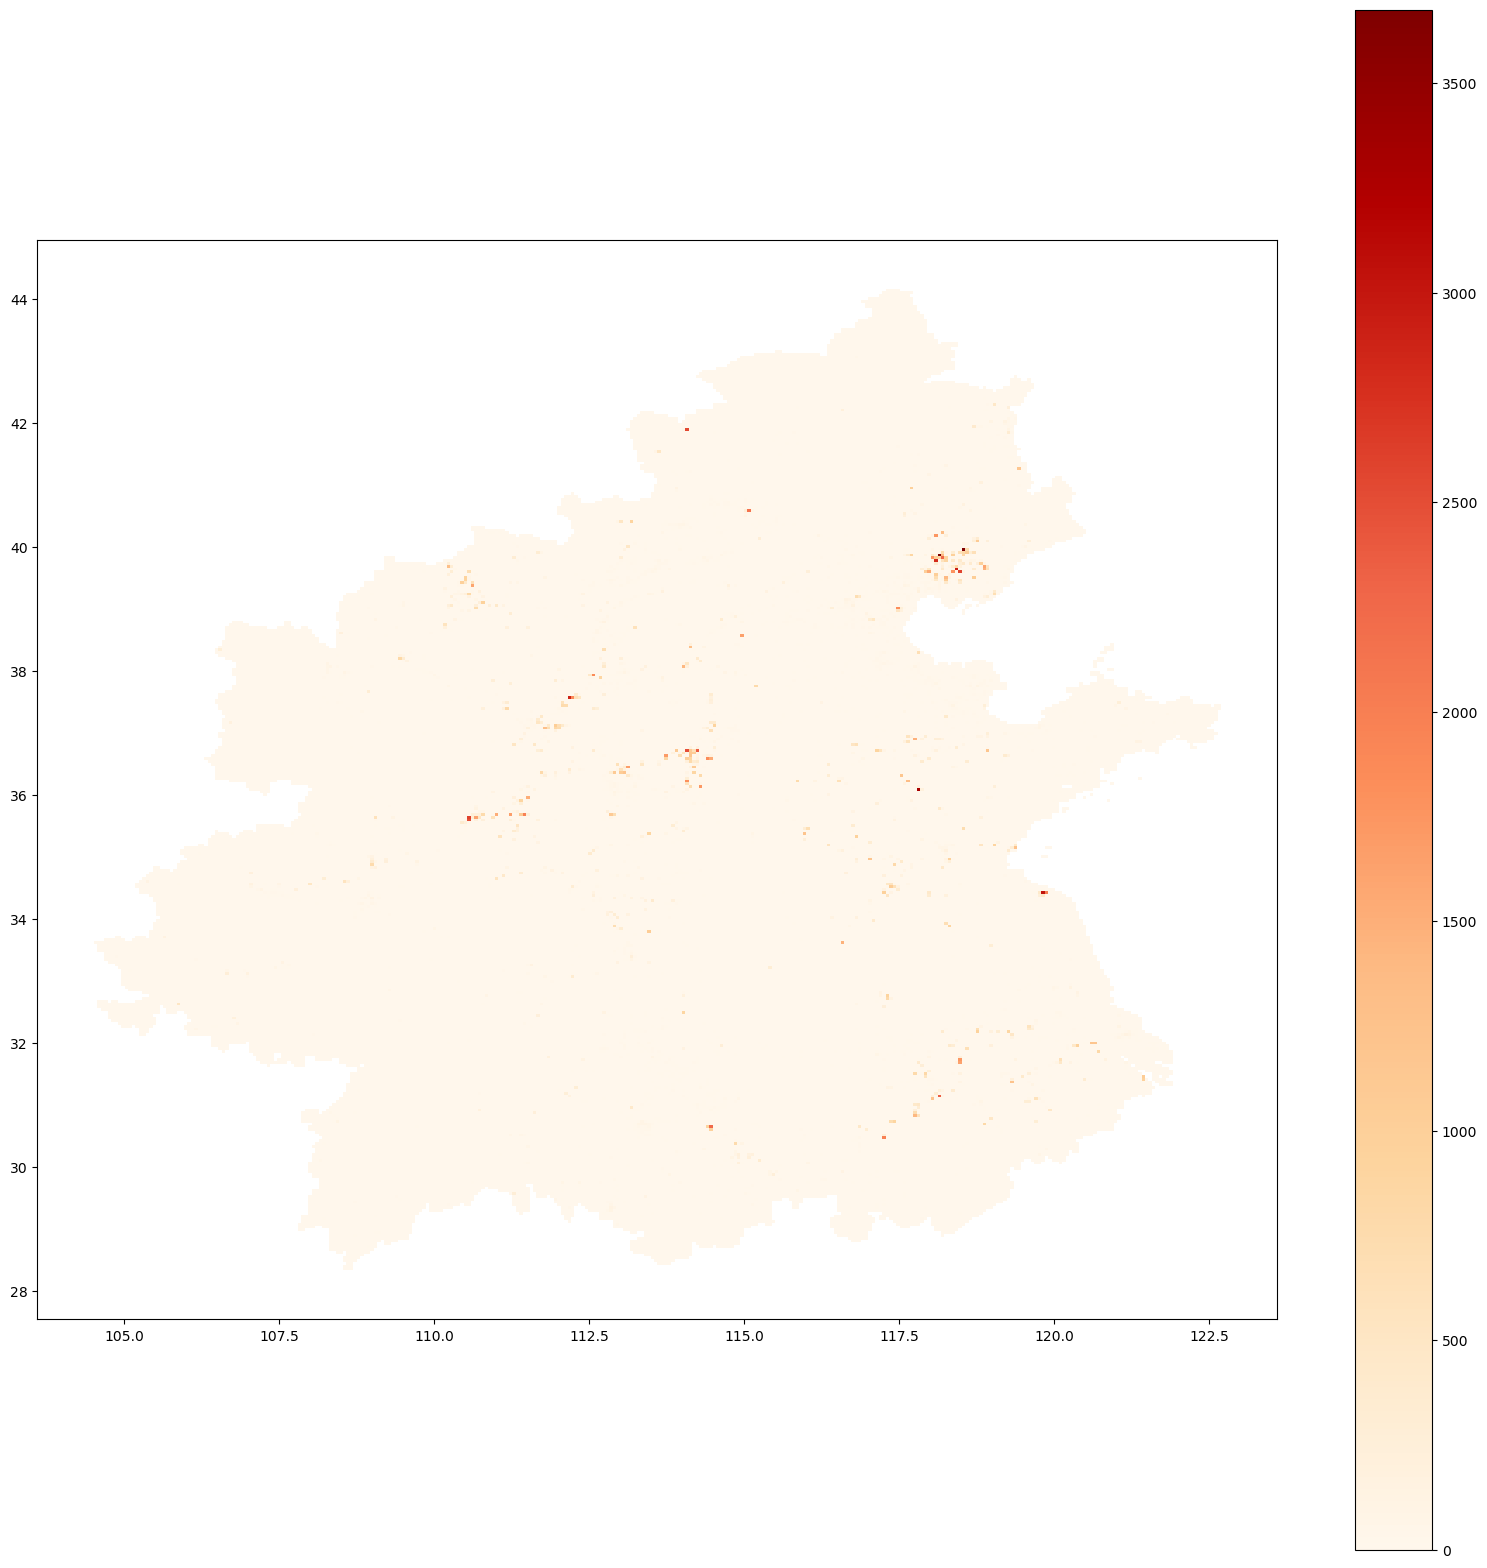

In [8]:
grid_with_fire = grid_with_fire[grid_with_fire.intersects(counties.unary_union)]
grid_with_fire.plot(column='fire', cmap='OrRd', legend=True, figsize=(20,20))

In [9]:
grid_with_fire.to_file("/Users/zwy/Library/CloudStorage/Dropbox/work files/Policy impact on fire/grid_with_fire_{}.shp".format(data_year))